In [1]:
import torch
import torchaudio
from pathlib import Path
from torch.utils.data import Dataset

In [2]:
file = Path('/Users/musaazeem/dev/who-opened-the-door/data/2024-04-03_15_07_57.ogg')
metadata = torchaudio.info(str(file))
sample_rate = metadata.sample_rate
n_frames = metadata.num_frames
n_channels = metadata.num_channels
encoding = metadata.encoding # VORBIS for .ogg files

In [3]:
class AudioDataset(Dataset):
    def __init__(self, audio_file, chunk_size=100_000_000):
        audio_file = str(audio_file)
        self.audio_file = audio_file
        self.chunk_size = chunk_size
        
        metadata = torchaudio.info(audio_file)
        self.num_chunks = metadata.num_frames // chunk_size

    def __len__(self):
        return self.num_chunks

    def __getitem__(self, idx):
        start_frame = idx * self.chunk_size
        audio_chunk, _ = torchaudio.load(self.audio_file, frame_offset=start_frame, num_frames=self.chunk_size)
        return audio_chunk
audioDataset = AudioDataset(file)

In [6]:
wave = audioDataset[0]
# number of mb in the audio file:
len(wave.flatten()) * wave.element_size() / 1e6

800.0

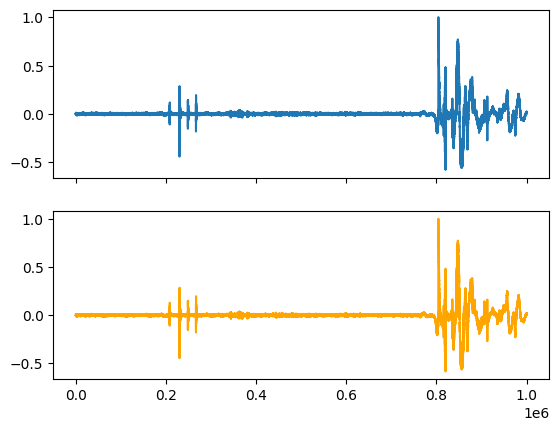

In [10]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(2, sharex=True)
axes[0].plot(wave[0,:1000000].numpy())
axes[1].plot(wave[1,:1000000].numpy(), color='orange')